Generate random captcha images used later for training and validation.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tqdm.auto import trange
import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')

dataset_dir = data_dir / 'dataset'
dataset_dir.mkdir(exist_ok=True, parents=True)

train_data_dir = dataset_dir / 'training'
train_data_dir.mkdir(exist_ok=True, parents=True)
val_data_dir = dataset_dir / 'validation'
val_data_dir.mkdir(exist_ok=True, parents=True)

tokenizer_path = dataset_dir / "tokenizer.json"

In [2]:
n_jobs = 16
n_images = 20000
image_per_file = 200
image_size = (400, 120)
watermark = "République Française - référendum d'initiative partagée"

word_length_min = 6
word_length_max = 10
font_name = "NimbusSanL-Bol.otf"

generator = captchanet.CaptchaGenerator(image_size=image_size, font_size=66, font_name=font_name)

# Create a tokenizer and save it.
vocabulary = list(generator.alphabet)
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, char_level=True, filters='')
tokenizer.fit_on_texts(vocabulary)
with open(tokenizer_path, 'w') as f:
  f.write(tokenizer.to_json())

# Split dataset for training and validation.
train_size = 0.8
train_n = int(n_images * train_size)

def generate_captcha(i):
  
  if (i * image_per_file) < train_n:
    writer_path = train_data_dir / f"{i:08d}.tfrecord"
  else:
    writer_path = val_data_dir / f"{i:08d}.tfrecord"

  # Save data to TFRecord.
  writer = tf.io.TFRecordWriter(str(writer_path))
  
  for _ in range(image_per_file):
    # Generate a random word and an image.
    word, image = generator(n_min=word_length_min, n_max=word_length_max, watermark=watermark)

    # Create TF feature and save it
    example = captchanet.encode_data(image, word, tokenizer, word_length_max)  
    writer.write(example.SerializeToString())
    
  writer.close()
  
args = np.arange(0, n_images // image_per_file)
_ = captchanet.utils.parallelized(generate_captcha, args, args_type='single', progress_bar=True, n_jobs=n_jobs)

W0712 19:28:10.871416 139733412775744 deprecation.py:323] From /home/hadim/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


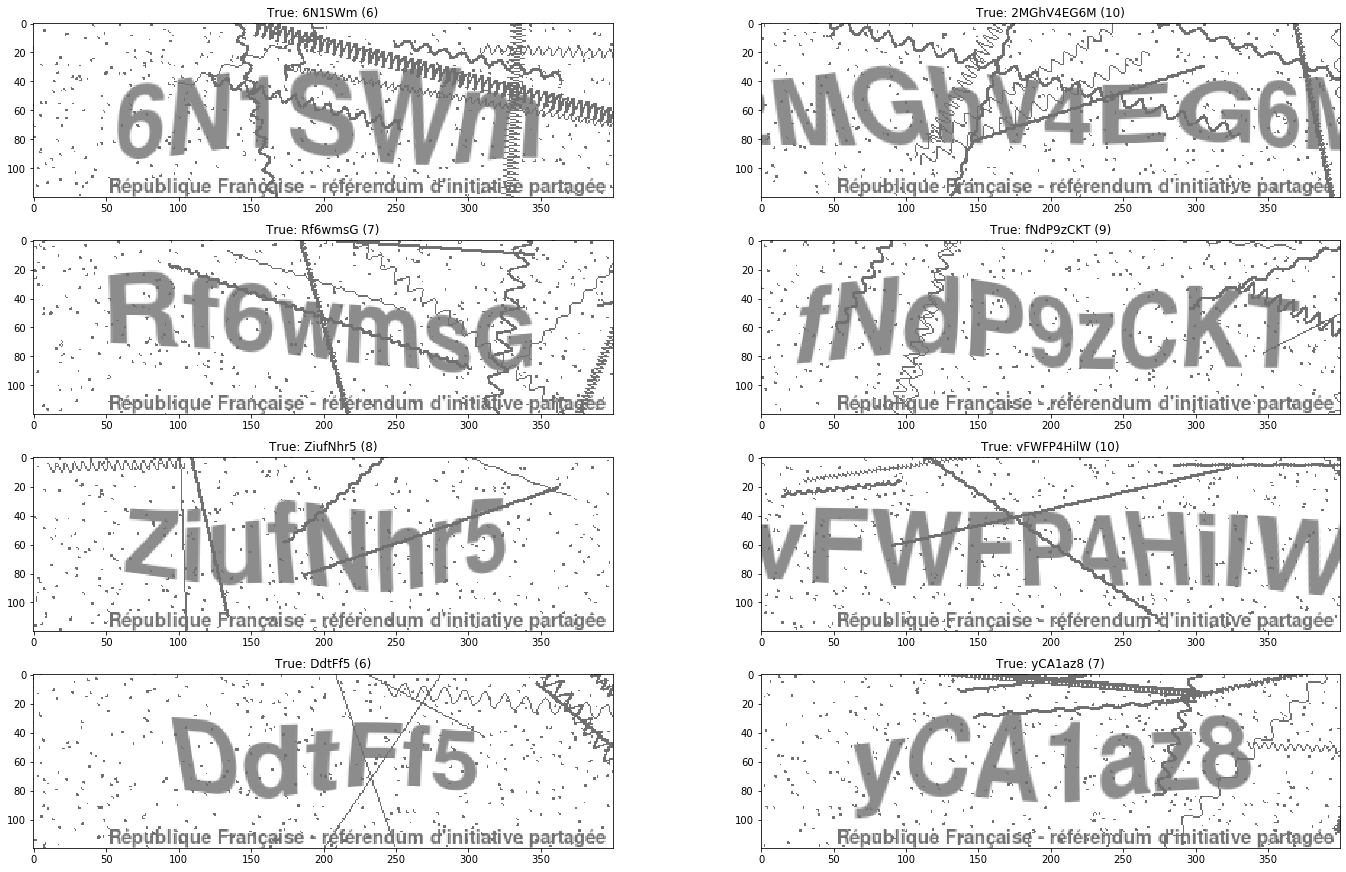

In [3]:
# Check the dataset by displaying some images.

n  = 8
fnames = [str(p) for p in train_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8') for w in words]

size = 3
ncols = 2
nrows = n // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(original_images, words, axs):
  ax.imshow(image)
  text = f'True: {word} ({len(word)})'
  ax.set_title(text)